# W261 Final Project

#### *Anusha Munjuluri, Arvindh Ganesan, Kim Vignola, Christina Papadimitriou*

### Notebook Set-up

In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

## 1. Question Formulation

## 2. Algorithm Explanation

### Data Loading and Pre-Processing

In [4]:
# take a look at the data
!head -n 1 data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16


In [70]:
# creating a small toy file
!head -n 1000 Data/train.txt >> data/train_head1000.txt

In [5]:
# load the data
fullTrainRDD = sc.textFile('data/train.txt')
testRDD = sc.textFile('data/test.txt')

FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']

In [10]:
# number of rows in train/test data
print(f"Number of records in train data: {fullTrainRDD.count()} ...")
print(f"Number of records in test data: {testRDD.count()} ...")

Number of records in train data: 45840617 ...
Number of records in test data: 6042135 ...


In [6]:
# Generate 80/20 (pseudo)random train/test split 
trainRDD, heldOutRDD = fullTrainRDD.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 9167871 records for evaluation and assigned 36672746 for training.


In [7]:
# helper functions
def parse(line):
    """
    Map line --> tuple of (features, label)
    """
    fields = line.split('\t')
    features,label = fields[1:], fields[0]
    return(features, label)

def edit_data_types(line):
    """
    Map tuple of (features, label) --> tuple of (formated features, label)
    
    * '' is replaced with 'null'
    * numerical fields are converted to integers
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == '':
            formated_features.append(np.nan)
        else:
            if i < 13:
                formated_features.append(int(value)) 
            else:
                formated_features.append(value)
    return (formated_features, label)

In [8]:
trainRDDCached = trainRDD.map(parse).map(edit_data_types).cache()

In [9]:
print(trainRDDCached.take(1))

[([1, 1, 5, 0, 1382, 4, 15, 2, 181, 1, 2, nan, 2, '68fd1e64', '80e26c9b', 'fb936136', '7b4723c4', '25c83c98', '7e0ccccf', 'de7995b8', '1f89b562', 'a73ee510', 'a8cd5504', 'b2cb9c98', '37c9c164', '2824a5f6', '1adce6ef', '8ba8b39a', '891b62e7', 'e5ba7672', 'f54016b9', '21ddcdc9', 'b1252a9d', '07b5194c', nan, '3a171ecb', 'c5c50484', 'e8b83407', '9727dd16'], '0')]


In [32]:
sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

In [36]:
sample_df.head(10)

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,Label
0,null,43,12,1,11180,null,0,4,10,null,...,25935396,21ddcdc9,5840adea,99c09e97,null,32c7478e,335a6a1e,001f3601,8d8eb391,0
1,null,0,31,4,3093,null,0,9,4,null,...,9efc6015,null,null,08168d73,null,32c7478e,9266d2b9,null,null,0
2,2,19,12,10,28,13,2,9,10,1,...,005c6740,21ddcdc9,5840adea,bf055581,null,32c7478e,1793a828,e8b83407,b9809574,0
3,1,0,null,null,1192,53,1,11,9,1,...,e7e991cb,21ddcdc9,a458ea53,9ee23d5c,null,c7dc6720,ae597d01,ea9a246c,ea90a691,0
4,null,2,1,null,28537,102,1,2,36,null,...,e7e991cb,1d1eb838,a458ea53,650c1a88,null,32c7478e,e39ca0cd,e8b83407,8bfe30cc,0
5,0,79,1,3,1369,9,5,12,50,0,...,744ad4a0,null,null,a17a10b3,null,3a171ecb,e5fca70a,null,null,1
6,null,1,69,7,234509,null,0,9,2,null,...,1f9656b8,21ddcdc9,b1252a9d,38483e30,null,32c7478e,1793a828,e8b83407,70b6702c,0
7,0,1,2,null,45146,null,null,7,null,0,...,8f0f692f,21ddcdc9,b1252a9d,cc6a9262,null,3a171ecb,a5862ce8,445bbe3b,5fdad95a,0
8,null,76,null,1,750,null,0,32,8,null,...,defd44e8,null,null,5a5953a2,c9d4222a,32c7478e,8f079aa5,null,null,0
9,2,1,8,8,324,11,4,20,147,1,...,891589e7,6f3756eb,a458ea53,f4ab3863,null,423fab69,18a58a01,f0f449dd,68df8ac4,1


In [ ]:
# # part a - take a look at histograms for each feature (RUN THIS CELL AS IS)
# sample_df[FIELDS[:13]].hist(figsize=(20,20), bins=15)
# plt.show()

## 3. EDA & Discussion of Challenges

### 3.1 Labels

In [82]:
# counting records for each class 
count_label_0 = trainRDDCached.filter(lambda x: x[1] == '0').count()
count_label_1 = trainRDDCached.filter(lambda x: x[1] == '1').count()
total = count_label_0 + count_label_1

print(f"{np.round(count_label_0/total*100, 2)} % of the records have label=0 and {np.round(count_label_1/total*100, 2)} % have label=1...")

74.38 % of the records have label=0 and 25.62 % have label=1...


### 3.2 Categorical Features

In [57]:
def plot_category_counts(dataRDD, var, var_position, top):
    """
    input: name and position of a categorical variable 
    
    output: 
    * number of unique categories in the variable
    * counts of each category occurance by label
    * plot of top X category counts for the variable 
    """
    # counting category occurance within each categorical variable (by label)
    count_per_category = dataRDD.map(lambda x: ( (x[1], x[0][var_position]), 1)) \
                                .reduceByKey(lambda x,y: x+y) \
                                .sortBy(lambda x: -x[1])

    # counting number of unique values within the categorical variable
    num_unique_values = count_per_category.map(lambda x: x[0][1]).distinct().count()

    print('Unique values within the category:', num_unique_values)
    print(' ')
    top10 = count_per_category.take(10)
    print('Top 10 categories by count:')
    for i in top10: 
        print('Category: {}; Label: {}; Count: {}'.format(i[0][1],i[0][0],i[1]))
    print(' ')
    
    # Ploting bar graphs of the top X category counts for the variable (by label)
    df = pd.DataFrame(count_per_category.map(lambda x: (x[0][0], x[0][1], x[1])).take(1000)) # we take a random large number 
    df.columns = ['label', 'category', 'count']
    df_plot = df.pivot('category','label').sort_values(('count','0'), ascending=False).head(top) # df_plot is a subset of df
    width = .4
    ind = np.arange(top)
    p1 = plt.bar(ind, df_plot['count']['0'], width, color='#d62728')
    p2 = plt.bar(ind, df_plot['count']['1'], width, bottom=df_plot['count']['0'])
    plt.ylabel('count')
    plt.title('Variable {}'.format(var))
    plt.xticks(ind, df_plot.index, rotation=90, fontsize=7)
    plt.legend((p1[0], p2[0]), ('1', '0'),loc='upper right')
    plt.show()

Unique values within the category: 633
 
Top 10 categories by count:
Category: 0b153874; Label: 0; Count: 16201742
Category: 0b153874; Label: 1; Count: 5584579
Category: 5b392875; Label: 0; Count: 4538102
Category: 1f89b562; Label: 0; Count: 2041973
Category: 5b392875; Label: 1; Count: 1563874
Category: 37e4aa92; Label: 0; Count: 1133414
Category: 062b5529; Label: 0; Count: 707730
Category: 1f89b562; Label: 1; Count: 702722
Category: 51d76abe; Label: 0; Count: 485571
Category: 37e4aa92; Label: 1; Count: 389988
 


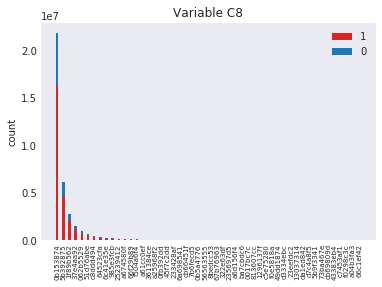

In [58]:
plot_category_counts(trainRDDCached, 'C8', var_position=20, top=50)

Unique values within the category: 1460
 
Top 10 categories by count:
Category: 05db9164; Label: 0; Count: 13654205
Category: 05db9164; Label: 1; Count: 4705450
Category: 68fd1e64; Label: 0; Count: 4551365
Category: 5a9ed9b0; Label: 0; Count: 2276407
Category: 68fd1e64; Label: 1; Count: 1567470
Category: 8cf07265; Label: 0; Count: 1350662
Category: be589b51; Label: 0; Count: 901451
Category: 5a9ed9b0; Label: 1; Count: 783874
Category: 5bfa8ab5; Label: 0; Count: 653927
Category: 87552397; Label: 0; Count: 486161
 


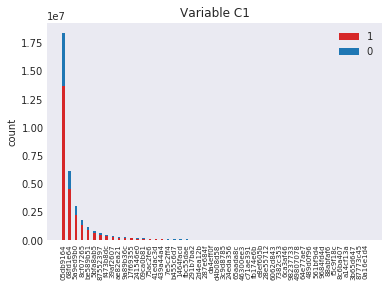

Unique values within the category: 578
 
Top 10 categories by count:
Category: 38a947a1; Label: 0; Count: 2892855
Category: 38a947a1; Label: 1; Count: 1305706
Category: 207b2d81; Label: 0; Count: 1290665
Category: 38d50e09; Label: 0; Count: 1158005
Category: 287130e0; Label: 0; Count: 982979
Category: 1cfdf714; Label: 0; Count: 964443
Category: 4f25e98b; Label: 0; Count: 921110
Category: 09e68b86; Label: 0; Count: 898783
Category: 421b43cd; Label: 0; Count: 691189
Category: 80e26c9b; Label: 0; Count: 654949
 


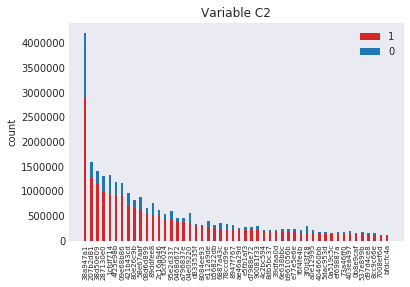

In [ ]:
for var_position, var in enumerate(FIELDS):
    if var_position>12 and var_position<39:
        plot_category_counts(trainRDDCached, var, var_position=var_position, top=50)

### 3.3 Numeric Features

## 4. Algorithm Implementation

## 5. Application of Course Concepts